In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from PIL import Image, ImageFile
import os

## Data

In [221]:
img_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

def display_original_image(image, elements, scale_x, scale_y):
    display_transform = transforms.Compose([
        transforms.Resize((int(128 / scale_y), int(128 / scale_x)))
    ])
    image = display_transform(image)  
    image = image.permute(1, 2, 0)  
    plt.imshow(image)
    
    box = elements[1:].numpy()
    rect = plt.Rectangle((box[0]/scale_x, box[1]/scale_y), box[2]/scale_x, box[3]/scale_y, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
    plt.show()



In [ ]:
class MyDataset(Dataset):
    def __init__(self, type , transform):
        with open(os.path.join('Data',type, '_annotations.coco.json'.format(type))) as f:
            self.dataset = json.load(f)
        self.categories = self.dataset["categories"]
        self.type = type
        self.transform = transform
    def __len__(self):
        return len(self.dataset["annotations"])
    def __getitem__(self, annotation_id):
        image_id = self.dataset["annotations"][annotation_id]["image_id"]
        
        image_path = self.dataset["images"][image_id]["file_name"]
        image = Image.open(os.path.join('Data',self.type, image_path))
        image = self.transform(image)
        
        scale_x = 128/self.dataset["images"][image_id]["width"]
        scale_y = 128/self.dataset["images"][image_id]["height"]
        
        category = self.dataset["annotations"][annotation_id]["category_id"]
        element = self.dataset["annotations"][annotation_id]["bbox"]
        element = [element[0]*scale_x, element[1]*scale_y, element[2]*scale_x, element[3]*scale_y]
        element = torch.tensor([category]+element)
        return image, element, scale_x, scale_y

In [273]:
Valid_dataset = MyDataset("valid", img_transforms)
Train_dataset = MyDataset("train", img_transforms)


In [274]:
def collate_fn(batch):
    images = []
    elements = []
    for b in batch:
        images.append(b[0])
        elements.append(b[1])
    images = torch.stack(images)
    elements = torch.stack(elements)
    return images, elements

In [275]:
batch_size = 64

In [276]:
train_loader = DataLoader(Train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(Valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

tensor([ 8.0000,  7.3593, 44.2880, 66.2341, 40.9600])


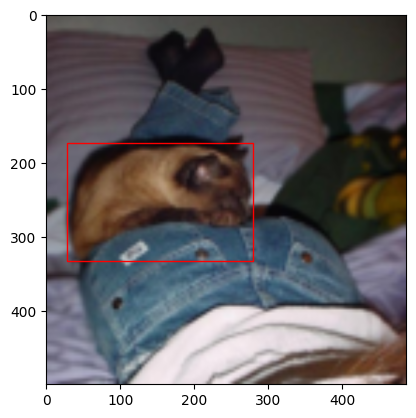

In [277]:
image, elements, scale_x, scale_y = Train_dataset.__getitem__(24)
print(elements)
display_original_image(image,elements, scale_x, scale_y)


## Model

In [228]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(64, 24),
        )
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [248]:
model = MyModel()

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

model.to(device)

MyModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=12

In [249]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [282]:
class ObjectDetectionLoss(nn.Module):
    def __init__(self, lambda_coord = 5.0):
        super(ObjectDetectionLoss, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()
        self.smooth_l1 = nn.SmoothL1Loss()
        self.lamdba = lambda_coord
    def forward(self, output, target):
        prediction_prob = output[:,:20]
        prediction_box = output[:,20:]
        
        target_prob = target[:,0].long()
        target_box = target[:,1:]
        
        classification_loss = self.cross_entropy(prediction_prob, target_prob)
        box_loss = self.smooth_l1(prediction_box, target_box)
        
        total_loss = classification_loss + self.lamdba * box_loss
        return total_loss       

In [283]:
criterion = ObjectDetectionLoss()

## Training

In [284]:
def find_lr(model, loss_fn, optimizer, train_loader, init_value=1e-8, final_value=10.0, device="cpu"):
    number_in_epoch = len(train_loader) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []
    for data in train_loader:
        batch_num += 1
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        if batch_num > 1 and loss > 4 * best_loss:
            if(len(log_lrs) > 20):
                return log_lrs[10:-5], losses[10:-5]
            else:
                return log_lrs, losses

        if loss < best_loss or batch_num == 1:
            best_loss = loss

        losses.append(loss.item())
        log_lrs.append((lr))

        loss.backward()
        optimizer.step()

        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr
        
    if(len(log_lrs) > 20):
        return log_lrs[10:-5], losses[10:-5]
    else:
        return log_lrs, losses      

In [285]:
log_lrs, losses = find_lr(model, criterion, optimizer, train_loader, device=device)

plt.plot(log_lrs, losses)
plt.xscale("log")
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.show()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [286]:
lr = 1e-4
omtimizer = optim.Adam(model.parameters(), lr=lr)

In [287]:
def train(model, optimizer, criterion, train_loader, val_loader, num_epochs, device = "cpu"):
    for epoch in range(num_epochs):
        model.train()
        trainning_loss = 0.0
        valid_loss = 0.0
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()
            trainning_loss += loss.item() * inputs.size(0)
        trainning_loss = trainning_loss / len(train_loader.dataset)
        

        model.eval()
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = criterion(output, targets)
            valid_loss += loss.item() * inputs.size(0)
        valid_loss = valid_loss / len(val_loader.dataset)
        
        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}'.format(epoch, trainning_loss, valid_loss))           

In [288]:
train(model, optimizer, criterion, train_loader, valid_loader, 10, device="cuda")

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


## Making Predictions

In [ ]:
image = Image.open(os.path.join(valid_loader, "2007_000033.jpg"))
image = img_transforms(image)
output = model(image.unsqueeze(0).to("cuda"))
output = output[0].detach().cpu().numpy()

boxes = output[1:].reshape(-1, 4)
boxes = boxes * 224
boxes = boxes.astype(np.int32)
boxes = boxes.tolist()

predictions = F.Softmax(output[:20],dim = 1)
class_idx = torch.argmax(predictions).item()
class_label = labels[class_idx]

fig, ax = plt.subplots()
ax.imshow(image.permute(1, 2, 0))